# related papers
http://journals.sagepub.com/doi/pdf/10.1177/0081175015576601

http://www.lifescienceglobal.com/pms/index.php/ijcs/article/view/5052/2853

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2770506

https://www.ijdp.org/article/S0955-3959(17)30288-8/abstract

http://article.socialsciencesjournal.org/pdf/10.11648.j.ss.20180702.15.pdf

https://www.sciencedirect.com/science/article/pii/S0091743503002330

https://www.sciencedirect.com/science/article/pii/S0013935109000498

https://onlinelibrary.wiley.com/doi/abs/10.1111/ecpo.12102

http://journals.sagepub.com/doi/abs/10.1177/0003122416663494

http://journals.sagepub.com/doi/pdf/10.1177/0022427806298356

https://waset.org/abstracts/environmental-and-ecological-engineering/76986

http://www.mdpi.com/2220-9964/7/2/43

http://discovery.ucl.ac.uk/11291/1/11291.pdf (hot spot report)

In [1]:
%matplotlib inline
import pandas as pd
from shapely.geometry import Point
import geopandas as gp

import datetime
from dateutil.relativedelta import relativedelta


from src import constants as C
from src.data_prep import prep_data_from_raw, prep_911, prep_crime

# load data

In [2]:
d911 = prep_911(by_category=False, gpdf=True, coords_series=False)
d911.reset_index(inplace=True)
d911.crs

{'init': 'epsg:3559', 'no_defs': True}

In [3]:
crimes = prep_crime(path='data/open-baltimore/clean/crimes-dev-set.csv',by_category=False, gpdf=True, coords_series=False)
crimes.reset_index(inplace=True)

In [4]:
# crimes = prep_data_from_raw('data/open-baltimore/raw/BPD_Part_1_Victim_Based_Crime_Data.csv', 
#                  col_lon='Longitude', col_lat='Latitude', col_date='CrimeDate', to_epsg=3559)

# crimes= crimes.loc['2015-01-01':]
# crimes['geometry'] = crimes.Coords.apply(lambda x: Point(*x))
# crimes = gp.GeoDataFrame(crimes)
# crimes.geometry = crimes.buffer(30)
# crimes.reset_index(inplace=True)
# crimes.crs = {'init': 'epsg:3559', 'no_defs': True}

# sjoin

In [5]:
# do sjoin per (Year, Month)
ym_crime = set(crimes.DateTime.apply(lambda x: (x.year, x.month)).unique())
ym_911 = set(d911.DateTime.apply(lambda x: (x.year, x.month)).unique())
yms = list(ym_crime & ym_911)
len(yms)

24

In [6]:
# sjoin within 100 meters
# d911.geometry = d911.buffer(30)
crimes_bf = crimes.copy()
crimes_bf.geometry = crimes_bf.buffer(100)

In [7]:
pairs = []
for y, m in yms:
    # - 1 day in case a crime happened just seconds before 1st of a month
    # include the 1st of next month in case a crime happend just seconds after this month
    # this may create duplicates, drop duplicates later
    date = datetime.datetime(year=y, month=m, day=1)
    start = date - datetime.timedelta(days=1)
    end = date + relativedelta(months=+1)
    
    # slice data by start and end date
    sted_crimes = crimes_bf[(crimes_bf.DateTime>=start) & (crimes_bf.DateTime<=end)]
    sted_d911 = d911[(d911.DateTime>=start) & (d911.DateTime<=end)]
    
    # Spatial constraint: 911 call is within X-meter radius of crime
    joined = gp.sjoin(sted_d911[['DateTime', 'geometry']], sted_crimes[['DateTime', 'geometry']])
    
    # DateTime constraint: 911 call is within 12 hours after crime happened, 
    # or 911 can also be within 1 hour before crime, considering the crimeTime may not be accurate
    joined = joined.reset_index().rename(columns={'index': 'i911', 'index_right': 'icrime'})
    joined['dt_diff'] = joined.apply(lambda x: (x.DateTime_left - x.DateTime_right).total_seconds()/3600, axis=1)
    cond = (joined.dt_diff >= -1) & (joined.dt_diff <= 12 )
    pairs.append(joined[cond][['i911', 'icrime', 'dt_diff']])
#     break

pairs = pd.concat(pairs, ignore_index=True)
# drop duplicates
pairs = pairs[~pairs.duplicated()]

In [8]:
crime_in_range = crimes[(crimes.DateTime>='2014-12-31') & (crimes.DateTime<='2017-01-01')]
d911_in_range = d911[(d911.DateTime>='2014-12-31') & (d911.DateTime<='2017-01-01')]
num_crimes = len(crime_in_range)
num_911 = len(d911_in_range)

In [9]:
idx_crimes = pairs.icrime.unique()
idx_911 = pairs.i911.unique()

In [10]:
'crime: %d/%d=%.02f, 911: %d/%d=%.02f' % (len(idx_crimes), num_crimes,len(idx_crimes) / num_crimes, len(idx_911), num_911, len(idx_911) / num_911)

'crime: 49714/92926=0.53, 911: 72460/634100=0.11'

In [10]:
'crime: %d/%d=%.02f, 911: %d/%d=%.02f' % (len(idx_crimes), num_crimes,len(idx_crimes) / num_crimes, len(idx_911), num_911, len(idx_911) / num_911)

'crime: 49714/92926=0.53, 911: 72460/634100=0.11'

# add info to pairs

In [11]:
# information to be added to pairs

col_c = ['DateTime', 'Category', 'Latitude', 'Longitude', 'Weapon', 'Neighborhood', 'In/Outside', 'Coords', 'geometry']
paired_c = crimes.loc[idx_crimes][col_c]
# col_c = [c+'_c' for c in col_c]
paired_c.columns = [c+'_c' for c in col_c]

col_9 = ['DateTime', 'Category', 'description', 'Latitude', 'Longitude', 'priority', 'Coords', 'geometry']
paired_9 = d911.loc[idx_911][col_9]
# col_9 = [c+'_9' for c in col_9]
paired_9.columns = [c+'_9' for c in col_9]

In [12]:
# for do-over merge
# pairs = pairs[['i911', 'icrime', 'dt_diff', 'distance']]

In [13]:
pairs = pairs.merge(paired_9, left_on='i911', right_index=True).merge(paired_c, left_on='icrime', right_index=True)

In [14]:
from scipy.spatial import distance
pairs['distance'] = pairs.apply(lambda x: distance.euclidean(x.Coords_9, x.Coords_c), axis=1)

In [15]:
# pairs.set_index(['icrime', 'Category_c', 'DateTime_c','i911']).sort_index()

In [16]:
# TODO: 911 call may be inaccurately mapped to multiple crimes
(pairs.groupby('i911').size()>1).sum()

pairs[pairs.i911.isin([436116])]

,i911,icrime,dt_diff,DateTime_9,Category_9,description_9,Latitude_9,Longitude_9,priority_9,Coords_9,...,DateTime_c,Category_c,Latitude_c,Longitude_c,Weapon_c,Neighborhood_c,In/Outside_c,Coords_c,geometry_c,distance
31283,436116,153293,6.600000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 12:00:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31311,436116,153296,7.183333,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 11:25:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31331,436116,153309,10.600000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 08:00:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31292,436116,153214,3.100000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 15:30:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31301,436116,153194,2.600000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 16:00:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31320,436116,153292,5.600000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 13:00:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31337,436116,153290,5.100000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 13:30:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31360,436116,153206,0.100000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 18:30:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31344,436116,153220,-0.400000,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 19:00:00,theft_larceny,39.34911,-76.67611,NaN,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335
31351,436116,153205,-0.066667,2016-05-21 18:36:00,assault,COMMON ASSAULT,39.349203,-76.676391,Medium,"(427894.2608454607, 186822.39437438943)",...,2016-05-21 18:40:00,assault,39.34911,-76.67611,HANDS,Pimlico Good Neighbors,O,"(427918.51885131863, 186812.155445374)",POINT (427918.5188513186 186812.155445374),26.330335


# agg by neighborhood

In [16]:
nb = gp.read_file('data/open-baltimore/raw/Education and Youth (2010-2013)  - Shape.geojson')[['csa2010', 'geometry']]

In [17]:
paired_9.columns = col_9
paired_c.columns = col_c

spatial join

In [18]:
join_p9_nb = gp.sjoin(paired_9.to_crs(epsg=4326), nb)
join_pc_nb = gp.sjoin(paired_c.to_crs(epsg=4326), nb)

In [118]:
min_report_time_diff = pairs.groupby('icrime').agg({'dt_diff':'min'})
join_pc_nb=join_pc_nb.join(min_report_time_diff)

In [19]:
# join_a9_nb = gp.sjoin(d911_in_range.to_crs(epsg=4326), nb)
join_ac_nb = gp.sjoin(crime_in_range.to_crs(epsg=4326), nb)

crime/911 statistics

In [20]:
num_911_per_crime = pairs.groupby('icrime').size().to_frame().rename(columns={0:'num_911'})

In [21]:
pair_by_nb = join_pc_nb[['csa2010']].join(num_911_per_crime).groupby('csa2010').agg(['count', 'mean', 'sum', 'std'])

In [22]:
pair_by_nb.columns = ['paired_crime', 'paired911/crime', 'paired_911', 'paired_std']

In [23]:
nb = nb.set_index('csa2010')

In [24]:
nb['all_crime'] = join_ac_nb.groupby('csa2010').size()

In [25]:
nb = nb.join(pair_by_nb)

In [26]:
nb['crime_pcnt'] = nb.paired_crime/nb.all_crime

time statistics

In [128]:
nb = nb.join(join_pc_nb.groupby('csa2010').agg({'dt_diff':'mean'}))

In [129]:
nb

,geometry,all_crime,paired_crime,paired911/crime,paired_911,paired_std,crime_pcnt,dt_diff
csa2010,,,,,,,,
Allendale/Irvington/S. Hilton,(POLYGON ((-76.65725523001441 39.2759942080963...,2098,898,1.507795,1354,0.919530,0.428027,2.440353
Beechfield/Ten Hills/West Hills,(POLYGON ((-76.69478913259752 39.3020045665433...,1072,470,1.565957,736,0.952446,0.438433,2.390194
Belair-Edison,(POLYGON ((-76.56761272099891 39.3263532793843...,2259,1221,1.682228,2054,1.160379,0.540505,1.869781
Brooklyn/Curtis Bay/Hawkins Point,"(POLYGON ((-76.588665947808 39.21281797207358,...",2443,1461,1.642026,2399,1.040212,0.598035,2.018449
Canton,(POLYGON ((-76.57139592708199 39.2844069466007...,850,455,1.382418,629,0.776101,0.535294,2.642673
Cedonia/Frankford,(POLYGON ((-76.52972064894043 39.3311259410992...,2764,1380,1.471739,2031,0.836919,0.499276,2.210708
Cherry Hill,(POLYGON ((-76.61525238024824 39.2410118053938...,1232,630,1.534921,967,0.892231,0.511364,2.006823
Chinquapin Park/Belvedere,(POLYGON ((-76.59490895201188 39.3540485873394...,830,379,1.532982,581,1.098746,0.456627,2.857388
Claremont/Armistead,(POLYGON ((-76.52974441466191 39.3101932770927...,975,430,1.455814,626,0.888492,0.441026,2.327349


# Research Questions

Vigilant neighborhood; over/under-reported neighborhood
1. how many crimes are reported
2. how quickly are crimes reported
3. duplicates reporting the same crime

correlate with socio-economic census


later
3. what types of crimes are reported (later)



In [43]:
indicators = pd.read_excel('data/open-baltimore/raw/VS16_Indicators_2010-2016.xlsx',sheetname='2015')
indicators = indicators.rename(columns={'CSA2010': 'csa2010'}).set_index('csa2010').drop('Baltimore City')

In [260]:
ind_2010 = pd.read_excel('data/open-baltimore/raw/VS16_Indicators_2010-2016.xlsx',sheetname='2010')
ind_2010 = ind_2010.rename(columns={'CSA2010': 'csa2010'}).set_index('csa2010').drop('Baltimore City')
population = ind_2010[['Total Population']]

In [72]:
from scipy.stats.mstats import normaltest
from scipy.stats import shapiro, pearsonr

In [130]:
nb.drop('geometry', axis=1).apply(lambda x: normaltest(x))

all_crime           (9.90272360775, 0.00707376928047)
paired_crime         (8.64364119123, 0.0132756918611)
paired911/crime     (10.9455897964, 0.00419947862535)
paired_911          (10.0238319634, 0.00665813421423)
paired_std          (26.5664827704, 1.7027918569e-06)
crime_pcnt            (2.78265093408, 0.248745382224)
dt_diff            (37.2986386518, 7.95616031537e-09)
dtype: object

In [255]:
y_cols = ['all_crime', 'paired_crime', 'paired_911', 'norm_crime', 'paired911/crime', 'crime_pcnt','dt_diff']

In [133]:
x_cols = indicators.columns.tolist()

In [241]:
nb_with_indicators = nb.join(population).join(indicators)

In [257]:
nb_with_indicators['norm_crime'] = nb_with_indicators['all_crime']/nb_with_indicators['Total Population']
# nb_with_indicators['norm_paired_crime'] = nb_with_indicators['paired_crime']/nb_with_indicators['Total Population']
# nb_with_indicators['norm_paired_911'] = nb_with_indicators['paired_911']/nb_with_indicators['Total Population']

In [265]:
# 'pearson', 'kendall', 'spearman'
nb_with_indicators[y_cols].corr('pearson')
# nb_with_indicators.drop(indicators.columns.tolist()+population.columns.tolist(), axis=1).corr()

,all_crime,paired_crime,paired_911,norm_crime,paired911/crime,crime_pcnt,dt_diff
all_crime,1.000000,0.978921,0.955514,0.648074,0.425754,0.471160,-0.519610
paired_crime,0.978921,1.000000,0.991075,0.678809,0.521669,0.613921,-0.574406
paired_911,0.955514,0.991075,1.000000,0.698741,0.615439,0.643395,-0.584588
norm_crime,0.648074,0.678809,0.698741,1.000000,0.529408,0.490782,-0.503503
paired911/crime,0.425754,0.521669,0.615439,0.529408,1.000000,0.650293,-0.562511
crime_pcnt,0.471160,0.613921,0.643395,0.490782,0.650293,1.000000,-0.713111
dt_diff,-0.519610,-0.574406,-0.584588,-0.503503,-0.562511,-0.713111,1.000000


In [246]:
res = []
for yc in y_cols:
#     if yc!='crime_pcnt':continue
    y = nb_with_indicators[yc]
    for xc in x_cols:
        if 'Household' not in xc: continue
        x = nb_with_indicators[xc]
        r,p = pearsonr(y,x)
        res.append({'yc': yc, 'xc':xc, 'r':r, 'abs_r': abs(r), 'p':p})
#         break
#     break

In [247]:
res_df = pd.DataFrame(res)[['yc','xc','r','abs_r','p']]

In [252]:
res_df[res_df.p<0.05]\
[res_df.yc.isin(['norm_crime', 'all_crime'])]\
.sort_values('r')\
.set_index(['xc','yc']).sort_index()

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


r  \
xc                                                 yc                     
Median Household Income                            all_crime  -0.371052   
                                                   norm_crime -0.293046   
Percent of Family Households Living Below the P... norm_crime  0.266209   
Percent of Female-Headed Households with Childr... all_crime   0.301288   
                                                   norm_crime  0.378627   
Percent of Households Earning Less than $25,000    all_crime   0.386687   
                                                   norm_crime  0.378766   
Percent of Households Earning More than $75,000    all_crime  -0.333415   
Percent of Households with No Vehicles Available   all_crime   0.471516   
                                                   norm_crime  0.467500   
Total Number of Households                         all_crime   0.431009   

                                                                  abs_r  \
xc                                                 yc                     
Median Household Income                            all_crime   0.371052   
                                                   norm_crime  0.293046   
Percent of Family Households Living Below the P... norm_crime  0.266209   
Percent of Female-Headed Households with Childr... all_crime   0.301288   
                                                   norm_crime  0.378627   
Percent of Households Earning Less than $25,000    all_crime   0.386687   
                                                   norm_crime  0.378766   
Percent of Households Earning More than $75,000    all_crime   0.333415   
Percent of Households with No Vehicles Available   all_crime   0.471516   
                                                   norm_crime  0.467500   
Total Number of Households                         all_crime   0.431009   

                                                                      p  
xc                                                 yc                    
Median Household Income                            all_crime   0.005289  
                                                   norm_crime  0.029909  
Percent of Family Households Living Below the P... norm_crime  0.049470  
Percent of Female-Headed Households with Childr... all_crime   0.025397  
                                                   norm_crime  0.004366  
Percent of Households Earning Less than $25,000    all_crime   0.003543  
                                                   norm_crime  0.004350  
Percent of Households Earning More than $75,000    all_crime   0.012864  
Percent of Households with No Vehicles Available   all_crime   0.000279  
                                                   norm_crime  0.000320  
Total Number of Households                         all_crime   0.001020

kmeans

In [231]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, Normalizer

In [232]:
scaler = MinMaxScaler()

data = nb.drop(['geometry', 'paired_std'], axis=1)

scaler.fit(data)

min_max_data = scaler.transform(data)

array([2, 0, 2, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 0, 1,
       0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 1, 2, 2, 2, 1, 0, 2, 2,
       1, 2, 2, 2, 1, 2, 1, 1, 2])

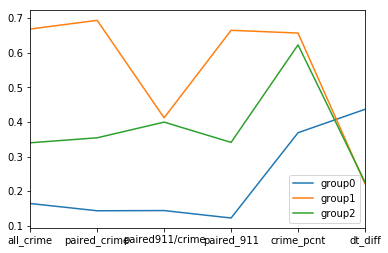

In [236]:
k=3
kmeans = KMeans(n_clusters=k).fit(min_max_data)
pd.DataFrame(kmeans.cluster_centers_, columns=data.columns,index=['group%d'%i for i in range(k)]).T.plot()

kmeans.labels_

# plot on map

## neighborhood

In [40]:
import folium
from folium import StepColormap, LinearColormap

In [42]:
def gpdf_bounds(gpdf):
    w = gpdf.bounds.minx.min()
    e = gpdf.bounds.maxx.max()
    s = gpdf.bounds.miny.min()
    n = gpdf.bounds.maxy.max()
    bound = [(s,w),(n,e)]
    return bound

In [85]:
linear(1.8)

'#ff5b5b'

In [103]:
gj??

In [114]:
linears = {}
for c in ['all_crime', 'paired_crime', 'paired911/crime', 'crime_pcnt']:
    mi, ma = nb[c].min(), nb[c].max()
    linear = LinearColormap(['white', 'red'],vmin=mi, vmax=ma)
    linears[c] = linear


In [117]:
m = folium.Map(tiles='CartoDB positron')
m.fit_bounds(gpdf_bounds(nb))

for c in ['all_crime', 'paired_crime', 'paired911/crime', 'crime_pcnt']:
    mi, ma = nb[c].min(), nb[c].max()
    linear = LinearColormap(['white', 'red'],vmin=mi, vmax=ma)
    gj = folium.GeoJson(nb[[c, 'geometry']],  name=c, 
                        style_function=lambda feature: {
                            'fillColor': linear(feature['properties']),
                            'color': 'black',
                            'weight': 2,
                            'dashArray': '5, 5',
                            'fillOpacity': 1
                        })
    gj.add_to(m)
    break
    
folium.LayerControl().add_to(m)

m.save('tmp/nb.html')

In [124]:
m = folium.Map(tiles='CartoDB positron')
m.fit_bounds(gpdf_bounds(nb))

mi, ma = nb['all_crime'].min(), nb['all_crime'].max()
gj = folium.GeoJson(nb[['all_crime', 'geometry']],  name='all_crime', 
                    style_function=lambda feature: {
                        'fillColor': linears['all_crime'](
                            feature['properties']['all_crime']),
                        'fillOpacity': 1
                    })
gj.add_to(m)

mi, ma = nb['paired_crime'].min(), nb['paired_crime'].max()
gj = folium.GeoJson(nb[['paired_crime', 'geometry']],  name='paired_crime', 
                    style_function=lambda feature: {
                        'fillColor': linears['paired_crime'](feature['properties']['paired_crime']),
                        'fillOpacity': 1
                    })
gj.add_to(m)

mi, ma = nb['paired911/crime'].min(), nb['paired911/crime'].max()
gj = folium.GeoJson(nb[['paired911/crime', 'geometry']],  name='paired911/crime', 
                    style_function=lambda feature: {
                        'fillColor': linears['paired911/crime'](feature['properties']['paired911/crime']),
                        'fillOpacity': 1
                    })
gj.add_to(m)

mi, ma = nb['crime_pcnt'].min(), nb['crime_pcnt'].max()
gj = folium.GeoJson(nb[['crime_pcnt', 'geometry']],  name='crime_pcnt', 
                    style_function=lambda feature: {
                        'fillColor': linears['crime_pcnt'](feature['properties']['crime_pcnt']),
                        'fillOpacity': 1
                    })
gj.add_to(m)
    
folium.LayerControl().add_to(m)

m.save('tmp/nb.html')

In [111]:
m.save??

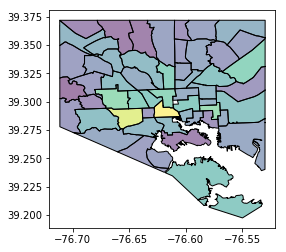

In [89]:
nb.plot(column='all_crime')

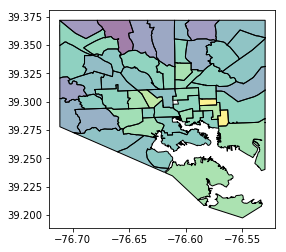

In [96]:
nb.plot(column='crime_pcnt')

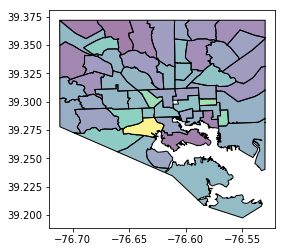

In [94]:
nb.plot(column='paired911/crime')

## marker cluster

In [11]:

from importlib import reload
import src.vis; reload(src.vis)
import src.vis.map; reload(src.vis.map)
from src.vis.map import marker_cluster, marker_cluster_fast


In [17]:
from wKit.vis.map import marker_cluster_fast

In [13]:
name_location = {
    'crimes': list(zip(target_c.Latitude.tolist(), target_c.Longitude.tolist())),
    '911': list(zip(target_9.Latitude.tolist(), target_9.Longitude.tolist()))
}

In [20]:
marker_cluster_fast(name_location, lonlat=False, filename='tmp/crime_911.html')